### Varatioanl AutoEncoder (VAE)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import glob
from tqdm.notebook import tqdm  # Notebook version for better progress bars
import warnings
warnings.filterwarnings('ignore')

# For better plotting
plt.style.use('seaborn-v0_8-darkgrid')

print("PyTorch version:", torch.__version__)

PyTorch version: 2.3.0



## 2. Device Configuration
Setting up MPS (Metal Performance Shaders) for Mac GPU acceleration, with fallback to CPU if needed.




In [2]:
def get_device():
    """Get the best available device (MPS for Mac, CUDA for Linux/Windows, CPU as fallback)"""
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✅ Using MPS (Metal Performance Shaders) for Mac GPU acceleration")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ Using CPU (No GPU acceleration available)")
    return device

device = get_device()

# Test MPS is working
if device.type == "mps":
    test_tensor = torch.randn(2, 3).to(device)
    print(f"MPS test successful: {test_tensor.device}")

✅ Using MPS (Metal Performance Shaders) for Mac GPU acceleration
MPS test successful: mps:0



## 3. Data Path Configuration
Configure paths for both local development and Rangpur cluster deployment.


In [3]:
# LOCAL PATH (for development on your Mac)
LOCAL_DATA_PATH = Path("./keras_png_slices_data")

# CLUSTER PATH (for Rangpur - commented out for local development)
# CLUSTER_DATA_PATH = Path("/home/groups/comp3710/keras_png_slices_data")

# Set the active path
DATA_PATH = LOCAL_DATA_PATH  # Change this to CLUSTER_DATA_PATH when on Rangpur
# DATA_PATH = CLUSTER_DATA_PATH  # Uncomment this line when on Rangpur

print(f"📁 Using data path: {DATA_PATH}")
print(f"📁 Path exists: {DATA_PATH.exists()}")

if DATA_PATH.exists():
    # List the subdirectories
    subdirs = [d.name for d in DATA_PATH.iterdir() if d.is_dir()]
    print(f"📂 Found subdirectories: {subdirs}")


📁 Using data path: keras_png_slices_data
📁 Path exists: True
📂 Found subdirectories: ['keras_png_slices_seg_test', 'keras_png_slices_test', 'keras_png_slices_train', 'keras_png_slices_seg_train', 'keras_png_slices_validate', 'keras_png_slices_seg_validate']


## 4. Explore Dataset Structure

Let's examine the structure of the keras_png_slices_data folder and understand how the data is organized.

In [4]:

# %%
def explore_keras_dataset_full(base_path):
    """Explore the keras PNG slices dataset structure - FULL VERSION"""
    
    base_path = Path(base_path)
    
    print("="*60)
    print("DATASET EXPLORATION (FULL)")
    print("="*60)
    
    # Define the expected subdirectories
    subdirs = ['keras_png_slices_seg_train', 'keras_png_slices_seg_test', 
            'keras_png_slices_seg_validate', 'keras_png_slices_train', 
            'keras_png_slices_test', 'keras_png_slices_validate']
    
    dataset_info = {}
    
    for subdir in subdirs:
        subdir_path = base_path / subdir
        if subdir_path.exists():
            # Get ALL PNG files this time
            png_files = list(subdir_path.glob('*.png'))
            dataset_info[subdir] = {
                'path': subdir_path,
                'count': len(png_files),
                'files': png_files  # Store ALL files, not just first 3
            }
            
            # Determine if it's segmentation or regular
            if 'seg' in subdir:
                print(f"🏷️  {subdir:35} : {len(png_files):6} segmentation masks")
            else:
                print(f"🖼️  {subdir:35} : {len(png_files):6} brain images")
    
    print("\n" + "="*60)
    
    # Check a sample image to get dimensions
    if dataset_info:
        sample_key = 'keras_png_slices_train'
        if sample_key in dataset_info and dataset_info[sample_key]['files']:
            sample_img = Image.open(dataset_info[sample_key]['files'][0])
            print(f"📐 Sample image size: {sample_img.size}")
            print(f"📐 Sample image mode: {sample_img.mode}")
    # %%
    # First, let's verify what we have
    print("🔍 Checking dataset_info variables:")
    if 'dataset_info' in locals():
        train_key = 'keras_png_slices_train'
        if train_key in dataset_info:
            print(f"   dataset_info has {len(dataset_info[train_key]['files'])} files")

    if 'dataset_info_full' in locals():
        train_key = 'keras_png_slices_train'
        if train_key in dataset_info_full:
            print(f"   dataset_info_full has {len(dataset_info_full[train_key]['files'])} files")
    return dataset_info



# Re-explore with ALL files
dataset_info_full = explore_keras_dataset_full(DATA_PATH)


DATASET EXPLORATION (FULL)
🏷️  keras_png_slices_seg_train          :   9664 segmentation masks
🏷️  keras_png_slices_seg_test           :    544 segmentation masks
🏷️  keras_png_slices_seg_validate       :   1120 segmentation masks
🖼️  keras_png_slices_train              :   9664 brain images
🖼️  keras_png_slices_test               :    544 brain images
🖼️  keras_png_slices_validate           :   1120 brain images

📐 Sample image size: (256, 256)
📐 Sample image mode: L
🔍 Checking dataset_info variables:
   dataset_info has 9664 files


## 5. Visualise Sample Images
Let's load and visualise some sample brain images and their corresponding segmentation masks.

📊 Found 9664 total brain images
📊 Displaying 12 samples


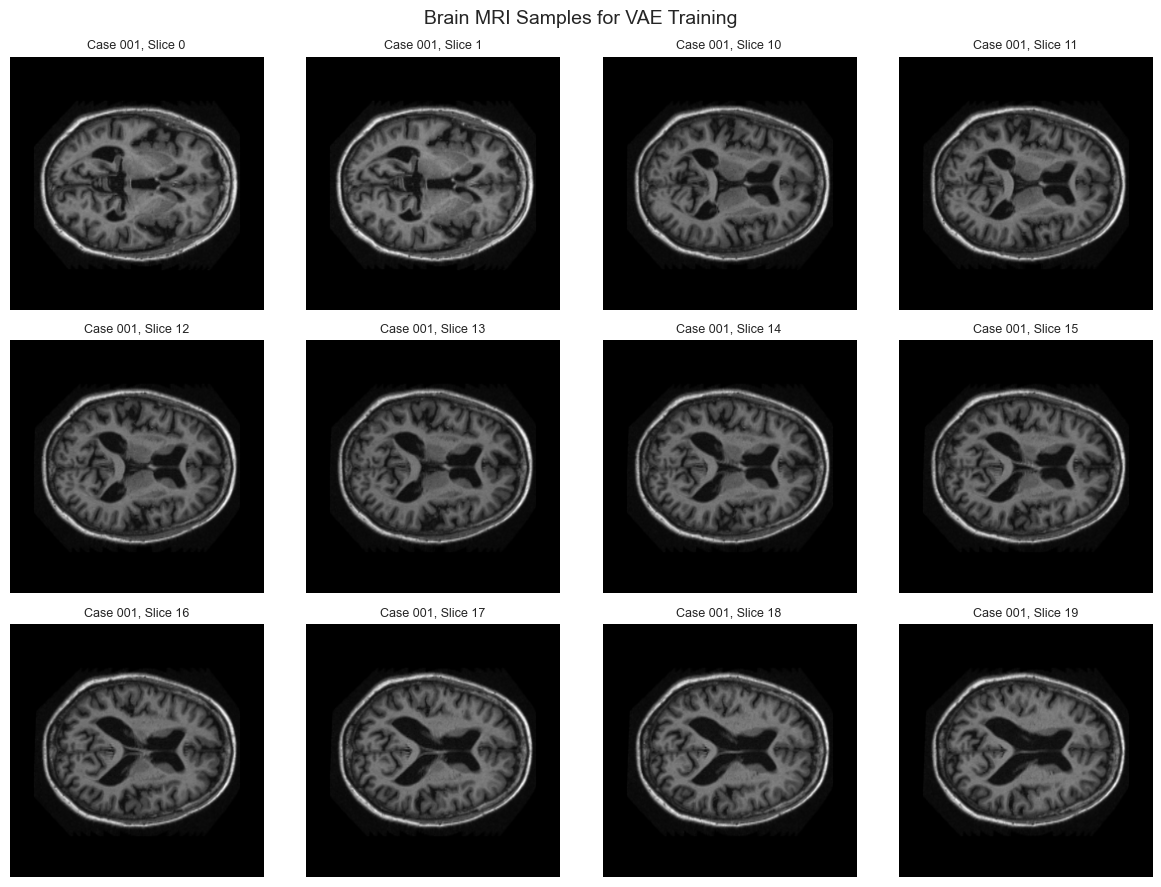


📈 Image Statistics:
   Shape: (256, 256)
   Value range: [0, 255]


In [5]:

# %%
# Now visualise with the correct variable
def visualize_brain_grid_corrected(num_samples=12):
    """Direct visualization to ensure we get all samples"""
    
    train_folder = DATA_PATH / 'keras_png_slices_train'
    all_files = sorted(list(train_folder.glob('*.png')))
    
    print(f"📊 Found {len(all_files)} total brain images")
    print(f"📊 Displaying {min(num_samples, len(all_files))} samples")
    
    # Select samples
    sample_files = all_files[:num_samples]
    
    # Create grid
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(sample_files))):
        img = Image.open(sample_files[i]).convert('L')
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Extract info
        parts = sample_files[i].name.split('_')
        if len(parts) >= 4:
            case = parts[1]
            slice_num = parts[3].split('.')[0]
            axes[i].set_title(f'Case {case}, Slice {slice_num}', fontsize=9)
    
    # Hide unused axes
    for i in range(len(sample_files), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Brain MRI Samples for VAE Training', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Show stats
    img_array = np.array(img)
    print(f"\n📈 Image Statistics:")
    print(f"   Shape: {img_array.shape}")
    print(f"   Value range: [{img_array.min()}, {img_array.max()}]")

# Run the corrected visualization
visualize_brain_grid_corrected(num_samples=12)


## 6. Create the Dataset Class for VAE Training

Now we'll create a proper PyTorch Dataset class that will handle all our brain images efficiently.

In [6]:
# %%
class BrainMRIDatasetVAE(Dataset):
    """Dataset class specifically for VAE training - handles all brain MRI images"""
    
    def __init__(self, data_dir, subset='train', image_size=64, max_samples=None):
        """
        Args:
            data_dir: Path to keras_png_slices_data directory
            subset: 'train', 'test', or 'validate'
            image_size: Size to resize images (assumes square)
            max_samples: Optional limit on number of samples (for quick testing)
        """
        self.data_dir = Path(data_dir)
        self.subset = subset
        self.image_size = image_size
        
        # Get the correct folder
        folder_name = f'keras_png_slices_{subset}'
        self.img_dir = self.data_dir / folder_name
        
        # Get all PNG files
        self.img_files = sorted(list(self.img_dir.glob('*.png')))
        
        # Optionally limit samples for testing
        if max_samples and len(self.img_files) > max_samples:
            self.img_files = self.img_files[:max_samples]
            print(f"   ⚠️ Limited to {max_samples} samples for testing")
        
        if len(self.img_files) == 0:
            raise ValueError(f"No PNG files found in {self.img_dir}")
        
        print(f"✅ VAE Dataset initialized: {folder_name}")
        print(f"   Loaded {len(self.img_files)} brain images")
        print(f"   Output size: {image_size}x{image_size}")
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert('L')  # Ensure grayscale
        
        # Resise to target size
        img = img.resize((self.image_size, self.image_size), Image.BILINEAR)
        
        # Convert to numpy and normalise to [0, 1]
        img_array = np.array(img, dtype=np.float32) / 255.0
        
        # Convert to tensor with channel dimension
        img_tensor = torch.FloatTensor(img_array).unsqueeze(0)  # Shape: [1, H, W]
        
        return img_tensor

# Test the dataset
print("🧪 Testing Dataset Creation...")
test_dataset = BrainMRIDatasetVAE(DATA_PATH, subset='train', image_size=64, max_samples=100)
print(f"   Test sample shape: {test_dataset[0].shape}")
print(f"   Test sample range: [{test_dataset[0].min():.2f}, {test_dataset[0].max():.2f}]")

🧪 Testing Dataset Creation...
   ⚠️ Limited to 100 samples for testing
✅ VAE Dataset initialized: keras_png_slices_train
   Loaded 100 brain images
   Output size: 64x64
   Test sample shape: torch.Size([1, 64, 64])
   Test sample range: [0.00, 0.70]


 ## 7. Create Data Loaders
Split the data into training, validation, and test sets with appropriate batch sizes.

In [7]:
# %%
# Create datasets for each subset
print("📊 Creating datasets for all subsets...")

# For initial testing, you can limit samples. Remove max_samples parameter for full training
QUICK_TEST = False  # Set to False for full dataset

if QUICK_TEST:
    max_samples = 500  # Quick testing
    print("⚡ Quick test mode: Using limited samples")
else:
    max_samples = None  # Use all data
    print("🔥 Full dataset mode: Using all available samples")

train_dataset = BrainMRIDatasetVAE(DATA_PATH, subset='train', image_size=64, max_samples=max_samples)
val_dataset = BrainMRIDatasetVAE(DATA_PATH, subset='validate', image_size=64, max_samples=max_samples)
test_dataset = BrainMRIDatasetVAE(DATA_PATH, subset='test', image_size=64, max_samples=max_samples)

print(f"\n📊 Dataset Summary:")
print(f"   Training:   {len(train_dataset):,} images")
print(f"   Validation: {len(val_dataset):,} images")
print(f"   Testing:    {len(test_dataset):,} images")
print(f"   Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,} images")

# Create data loaders
BATCH_SIZE = 32  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✅ Data loaders created")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📊 Creating datasets for all subsets...
🔥 Full dataset mode: Using all available samples
✅ VAE Dataset initialized: keras_png_slices_train
   Loaded 9664 brain images
   Output size: 64x64
✅ VAE Dataset initialized: keras_png_slices_validate
   Loaded 1120 brain images
   Output size: 64x64
✅ VAE Dataset initialized: keras_png_slices_test
   Loaded 544 brain images
   Output size: 64x64

📊 Dataset Summary:
   Training:   9,664 images
   Validation: 1,120 images
   Testing:    544 images
   Total:      11,328 images

✅ Data loaders created
   Batch size: 32
   Training batches: 302
   Validation batches: 35
   Test batches: 17


## 8. Define the VAE Architecture

Now let's build our Variational Autoencoder with:
- Convolutional encoder to compress images to latent space
- Reparameterization trick for sampling
- Deconvolutional decoder to reconstruct images

In [8]:
class VAE(nn.Module):
    """Variational Autoencoder for Brain MRI"""
    
    def __init__(self, image_size=64, latent_dim=20):
        super(VAE, self).__init__()
        
        self.image_size = image_size
        self.latent_dim = latent_dim
        
        # After 4 conv layers with stride 2: size becomes image_size / 16
        self.encoded_size = image_size // 16  # 64 // 16 = 4
        
        # ===== ENCODER =====
        self.encoder = nn.Sequential(
            # 1 x 64 x 64 -> 32 x 32 x 32
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # 32 x 32 x 32 -> 64 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 64 x 16 x 16 -> 128 x 8 x 8
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 128 x 8 x 8 -> 256 x 4 x 4
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Latent space parameters
        self.flatten_size = 256 * self.encoded_size * self.encoded_size
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # ===== DECODER =====
        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        
        self.decoder = nn.Sequential(
            # 256 x 4 x 4 -> 128 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 128 x 8 x 8 -> 64 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 64 x 16 x 16 -> 32 x 32 x 32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            # 32 x 32 x 32 -> 1 x 64 x 64
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        """Encode input to latent distribution parameters"""
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + eps * std"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode from latent space to image"""
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, self.encoded_size, self.encoded_size)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        """Complete forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Initialise model
LATENT_DIM = 20  # Size of latent space
model = VAE(image_size=64, latent_dim=LATENT_DIM).to(device)

print(f"✅ VAE Model initialized on {device}")
print(f"   Architecture: Convolutional VAE")
print(f"   Latent dimension: {LATENT_DIM}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
with torch.no_grad():
    test_batch = torch.randn(2, 1, 64, 64).to(device)
    test_recon, test_mu, test_logvar = model(test_batch)
    print(f"\n   Test forward pass successful:")
    print(f"   Input shape:  {test_batch.shape}")
    print(f"   Output shape: {test_recon.shape}")
    print(f"   Latent μ:     {test_mu.shape}")
    print(f"   Latent log σ²: {test_logvar.shape}")

✅ VAE Model initialized on mps
   Architecture: Convolutional VAE
   Latent dimension: 20
   Total parameters: 1,026,729

   Test forward pass successful:
   Input shape:  torch.Size([2, 1, 64, 64])
   Output shape: torch.Size([2, 1, 64, 64])
   Latent μ:     torch.Size([2, 20])
   Latent log σ²: torch.Size([2, 20])



## 9. Define Loss Function and Training Setup

The VAE loss combines:
- **Reconstruction loss**: How well we can reconstruct the input
- **KL divergence**: How close the latent distribution is to a standard normal

In [9]:
# %%
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = BCE + beta * KLD
    
    return total_loss, BCE, KLD

# Training function for one epoch
def train_epoch(model, dataloader, optimizer, beta=1.0):
    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for batch_idx, data in enumerate(progress_bar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item()/len(data):.4f}'})
    
    # Return average losses
    n = len(dataloader.dataset)
    return train_loss/n, train_bce/n, train_kld/n

# Validation function
def validate_epoch(model, dataloader, beta=1.0):
    model.eval()
    val_loss = 0
    val_bce = 0
    val_kld = 0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Validation', leave=False):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = vae_loss(recon_batch, data, mu, logvar, beta)
            
            val_loss += loss.item()
            val_bce += bce.item()
            val_kld += kld.item()
    
    n = len(dataloader.dataset)
    return val_loss/n, val_bce/n, val_kld/n

print("✅ Loss functions and training utilities defined")

✅ Loss functions and training utilities defined



## 10. Training Configuration and Setup
Configure hyperparameters and initialise the training process.


In [10]:
# %%
# Hyperparameters
EPOCHS = 20  # Start with 20, increase if needed
LEARNING_RATE = 1e-3
BETA = 1.0  # Weight for KL divergence (β-VAE parameter)

# Initialise model, optimizer, and scheduler
model = VAE(image_size=64, latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

print("🎯 Training Configuration:")
print(f"   Epochs:        {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Beta (β):      {BETA}")
print(f"   Device:        {device}")
print(f"   Optimizer:     Adam")
print(f"   Scheduler:     ReduceLROnPlateau (patience=5)")

🎯 Training Configuration:
   Epochs:        20
   Learning Rate: 0.001
   Beta (β):      1.0
   Device:        mps
   Optimizer:     Adam
   Scheduler:     ReduceLROnPlateau (patience=5)


## 11. Training Loop
 Now let's train the VAE! This will take a few minutes depending on your hardware.


In [ ]:
# %%
# Initialise history tracking
history = {
    'train_loss': [], 'train_bce': [], 'train_kld': [],
    'val_loss': [], 'val_bce': [], 'val_kld': []
}

print("\n" + "="*60)
print("🚀 Starting VAE Training")
print("="*60)

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    print(f"\n📍 Epoch {epoch}/{EPOCHS}")
    print("-" * 40)
    
    # Training
    train_loss, train_bce, train_kld = train_epoch(model, train_loader, optimizer, BETA)
    
    # Validation
    val_loss, val_bce, val_kld = validate_epoch(model, val_loader, BETA)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_bce'].append(train_bce)
    history['train_kld'].append(train_kld)
    history['val_loss'].append(val_loss)
    history['val_bce'].append(val_bce)
    history['val_kld'].append(val_kld)
    
    # Print metrics
    print(f"📈 Train - Loss: {train_loss:.4f} | BCE: {train_bce:.4f} | KLD: {train_kld:.4f}")
    print(f"📊 Val   - Loss: {val_loss:.4f} | BCE: {val_bce:.4f} | KLD: {val_kld:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, 'best_vae_model.pth')
        print("💾 New best model saved!")

print("\n" + "="*60)
print("✅ Training Complete!")
print(f"   Best epoch: {best_epoch}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print("="*60)


🚀 Starting VAE Training

📍 Epoch 1/20
----------------------------------------


Training:   0%|          | 0/302 [00:00<?, ?it/s]

## 12. Visualise Training History
Let's plot the training curves to see how well our model learned.

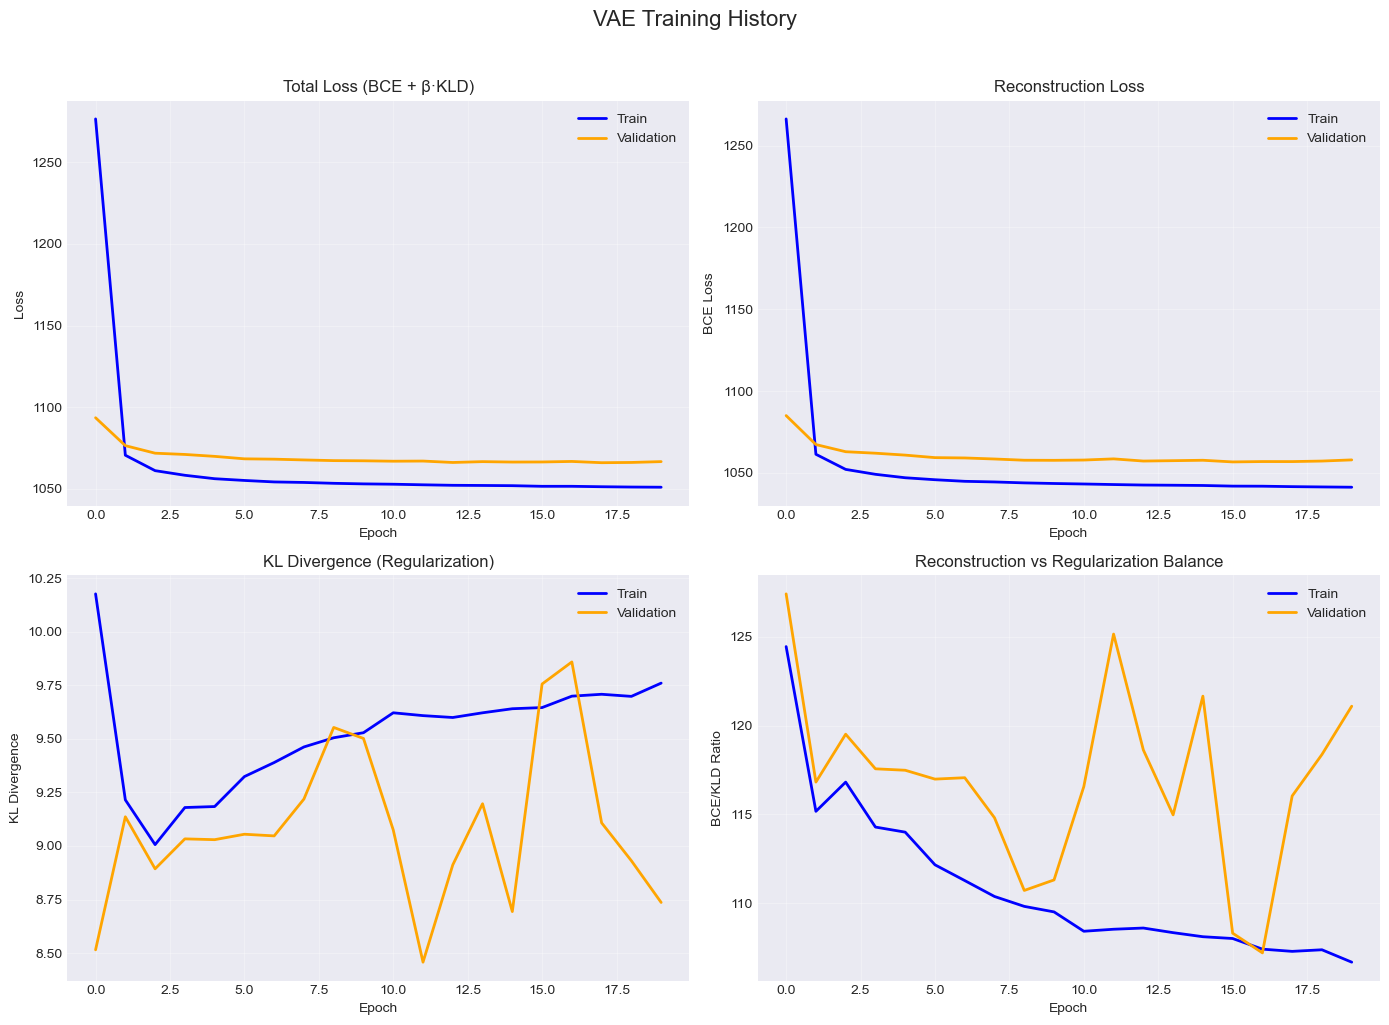

In [ ]:
# %%
def plot_training_history(history):
    """Plot comprehensive training history"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss (BCE + β·KLD)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[0, 1].plot(history['train_bce'], label='Train', linewidth=2, color='blue')
    axes[0, 1].plot(history['val_bce'], label='Validation', linewidth=2, color='orange')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('BCE Loss')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # KL Divergence
    axes[1, 0].plot(history['train_kld'], label='Train', linewidth=2, color='blue')
    axes[1, 0].plot(history['val_kld'], label='Validation', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('KL Divergence')
    axes[1, 0].set_title('KL Divergence (Regularization)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss Components Ratio
    train_ratio = np.array(history['train_bce']) / (np.array(history['train_kld']) + 1e-8)
    val_ratio = np.array(history['val_bce']) / (np.array(history['val_kld']) + 1e-8)
    axes[1, 1].plot(train_ratio, label='Train', linewidth=2, color='blue')
    axes[1, 1].plot(val_ratio, label='Validation', linewidth=2, color='orange')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('BCE/KLD Ratio')
    axes[1, 1].set_title('Reconstruction vs Regularization Balance')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('VAE Training History', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_training_history(history)


## 13. Visualise Reconstructions
Let's see how well our VAE can reconstruct brain images!

🖼️ Reconstruction Quality on Test Set:


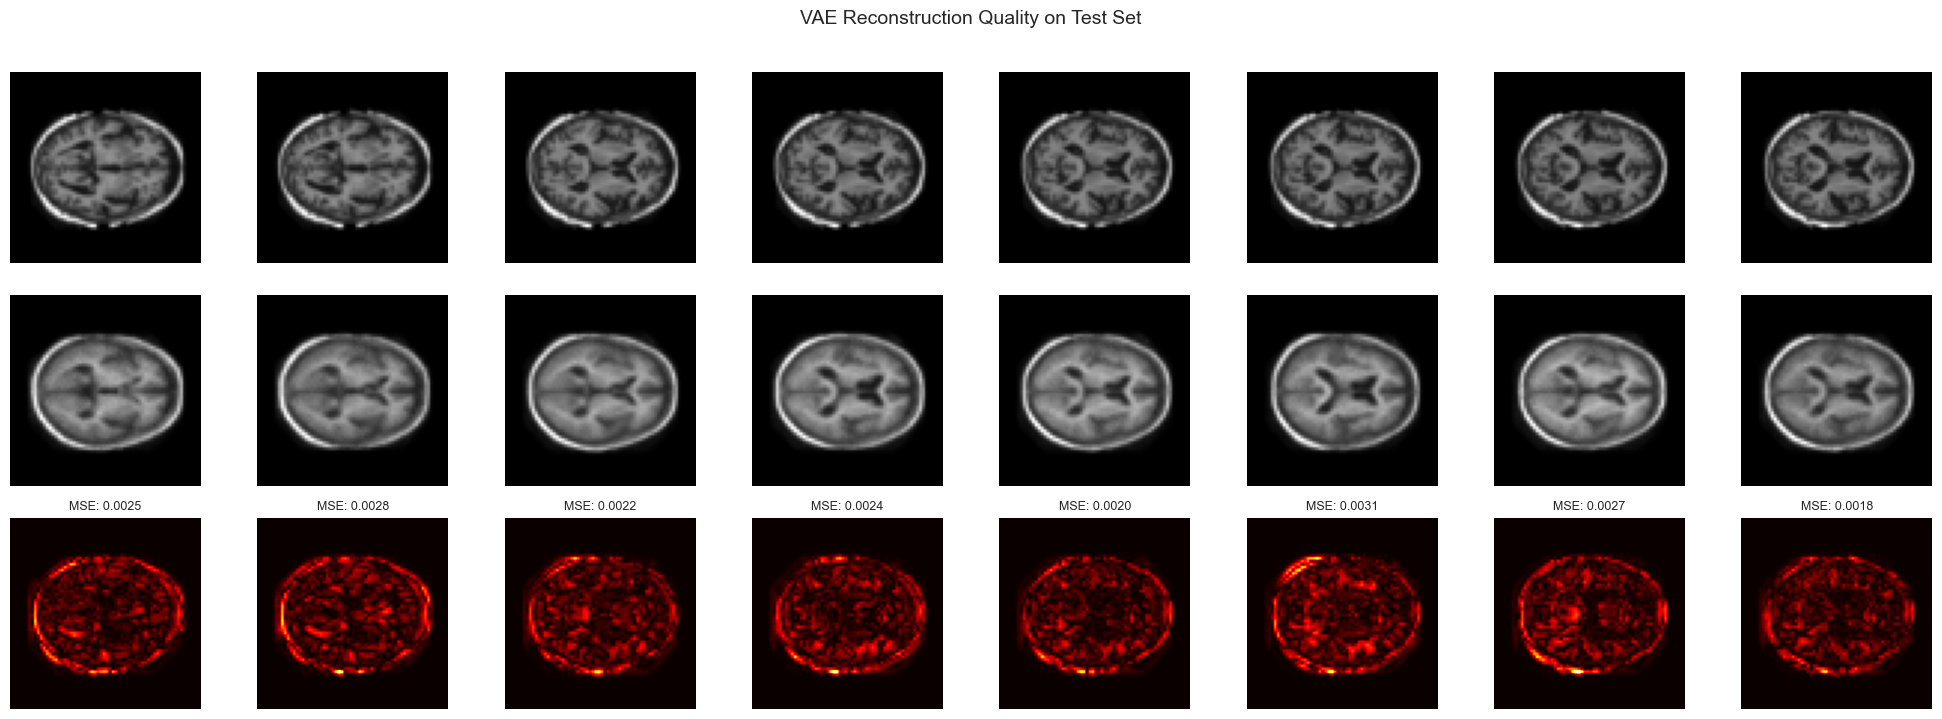

In [ ]:
# %%
def visualize_reconstructions(model, dataloader, num_images=8):
    """Compare original images with VAE reconstructions"""
    model.eval()
    
    with torch.no_grad():
        # Get a batch
        data = next(iter(dataloader))
        data = data.to(device)[:num_images]
        
        # Get reconstructions
        recon, mu, logvar = model(data)
        
        # Calculate MSE for each image
        mse_errors = F.mse_loss(recon, data, reduction='none').mean(dim=[1,2,3])
        
        # Move to CPU
        data = data.cpu()
        recon = recon.cpu()
        mse_errors = mse_errors.cpu()
        
        # Plot
        fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2.5, 7))
        
        for i in range(num_images):
            # Original
            axes[0, i].imshow(data[i, 0], cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12, rotation=0, labelpad=40, ha='right')
            
            # Reconstruction
            axes[1, i].imshow(recon[i, 0], cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Reconstructed', fontsize=12, rotation=0, labelpad=40, ha='right')
            
            # Difference
            diff = torch.abs(data[i, 0] - recon[i, 0])
            im = axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
            axes[2, i].axis('off')
            axes[2, i].set_title(f'MSE: {mse_errors[i]:.4f}', fontsize=9)
            if i == 0:
                axes[2, i].set_ylabel('Difference', fontsize=12, rotation=0, labelpad=40, ha='right')
        
        plt.suptitle('VAE Reconstruction Quality on Test Set', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

print("🖼️ Reconstruction Quality on Test Set:")
visualize_reconstructions(model, test_loader)


## 14. Generate New Brain Images
Sample from the latent space to generate completely new brain images!

🎨 Generating new brain images from learned distribution:


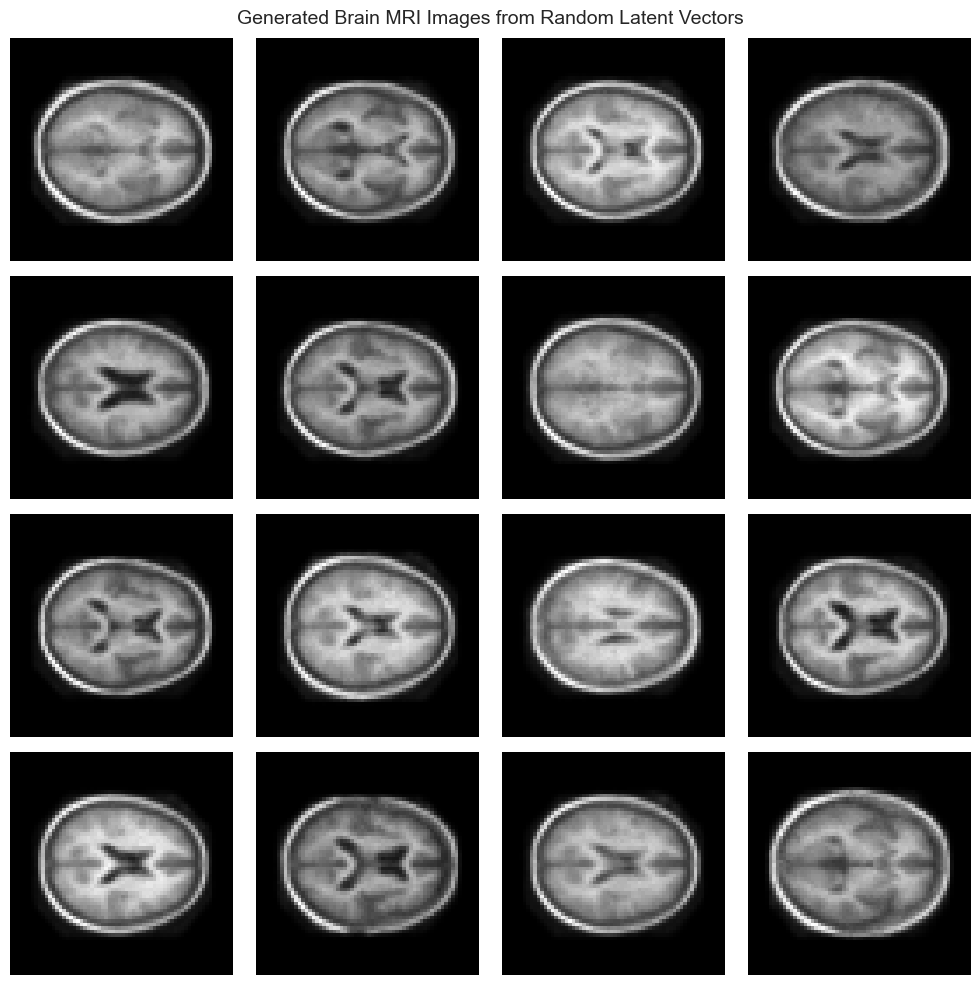

In [ ]:
# %%
def generate_new_samples(model, num_samples=16, latent_dim=LATENT_DIM):
    """Generate new brain images by sampling from latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Decode to generate images
        generated = model.decode(z).cpu()
        
        # Plot
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        axes = axes.flatten()
        
        for i in range(num_samples):
            axes[i].imshow(generated[i, 0], cmap='gray')
            axes[i].axis('off')
        
        plt.suptitle('Generated Brain MRI Images from Random Latent Vectors', fontsize=14)
        plt.tight_layout()
        plt.show()
        
    return generated

print("🎨 Generating new brain images from learned distribution:")
generated_samples = generate_new_samples(model, num_samples=16)

In [ ]:
# %% [markdown]
# ## Fix UMAP Installation Issues
# 
# We need to install compatible versions of scikit-learn and UMAP.

# %%
# First, let's fix the scikit-learn version issue
import subprocess
import sys

print("🔧 Fixing package compatibility issues...")

# Uninstall and reinstall with compatible versions
commands = [
    [sys.executable, "-m", "pip", "uninstall", "umap-learn", "scikit-learn", "-y"],
    [sys.executable, "-m", "pip", "install", "scikit-learn==1.3.0"],
    [sys.executable, "-m", "pip", "install", "umap-learn==0.5.4"]
]

for cmd in commands:
    print(f"Running: {' '.join(cmd)}")
    subprocess.check_call(cmd)

print("✅ Packages reinstalled with compatible versions")

# Now restart the kernel and try again
print("\n⚠️ IMPORTANT: Please restart your Jupyter kernel now!")
print("   Kernel -> Restart Kernel")
print("   Then run the next cell")

# %% [markdown]
# ## Alternative: Use t-SNE Instead of UMAP
# 
# If UMAP continues to have issues, t-SNE is another excellent non-linear dimensionality reduction technique 
# that's already included with scikit-learn.

# %%
# Alternative visualization using t-SNE (no additional installation needed)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def visualize_latent_space_comparison(model, dataloader, max_samples=1000):
    """
    Compare PCA and t-SNE visualizations of the latent space
    t-SNE is similar to UMAP but already included in scikit-learn
    """
    model.eval()
    
    print("📊 Extracting latent representations...")
    latents = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(dataloader, desc='Extracting latents')):
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            
            if len(latents) * BATCH_SIZE >= max_samples:
                break
    
    latents = np.concatenate(latents, axis=0)[:max_samples]
    print(f"   Extracted {latents.shape[0]} latent vectors of dimension {latents.shape[1]}")
    
    # Standardize the data
    scaler = StandardScaler()
    latents_scaled = scaler.fit_transform(latents)
    
    # Create figure with PCA and t-SNE
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # ========== PCA (left) ==========
    print("\n🔄 Computing PCA projection...")
    pca = PCA(n_components=2)
    pca_projection = pca.fit_transform(latents_scaled)
    
    scatter1 = axes[0].scatter(pca_projection[:, 0], pca_projection[:, 1], 
                               c=np.arange(len(pca_projection)), cmap='viridis', 
                               alpha=0.6, s=20, edgecolors='white', linewidth=0.5)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0].set_title('PCA Projection (Linear)', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # PCA info box
    pca_text = f'Linear projection\nPreserves global structure\nVariance explained: {pca.explained_variance_ratio_.sum():.1%}'
    axes[0].text(0.02, 0.98, pca_text, transform=axes[0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # ========== t-SNE (right) ==========
    print("🔄 Computing t-SNE projection (this may take a moment)...")
    
    # t-SNE parameters
    tsne = TSNE(
        n_components=2,
        perplexity=30,  # Similar to n_neighbors in UMAP
        learning_rate='auto',
        init='random',
        random_state=42,
        n_iter=1000
    )
    
    tsne_projection = tsne.fit_transform(latents_scaled)
    
    scatter2 = axes[1].scatter(tsne_projection[:, 0], tsne_projection[:, 1], 
                               c=np.arange(len(tsne_projection)), cmap='viridis', 
                               alpha=0.6, s=20, edgecolors='white', linewidth=0.5)
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].set_title('t-SNE Projection (Non-linear)', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    # t-SNE info box
    tsne_text = f'Non-linear projection\nPreserves local structure\nPerplexity: {tsne.perplexity}'
    axes[1].text(0.02, 0.98, tsne_text, transform=axes[1].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Add colorbars
    plt.colorbar(scatter1, ax=axes[0], label='Sample Index')
    plt.colorbar(scatter2, ax=axes[1], label='Sample Index')
    
    plt.suptitle(f'VAE Latent Space Visualization: Linear vs Non-linear\n(Latent dimension: {LATENT_DIM})', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return pca_projection, tsne_projection

# Use t-SNE as alternative to UMAP
print("\n🔍 Visualizing latent space with PCA and t-SNE:")
pca_proj, tsne_proj = visualize_latent_space_comparison(model, test_loader, max_samples=500)

# %% [markdown]
# ## Explore t-SNE Parameters
# 
# Similar to UMAP, t-SNE has parameters that affect the visualization.

# %%
def explore_tsne_parameters(model, dataloader, max_samples=400):
    """
    Explore how different t-SNE parameters affect visualization
    """
    model.eval()
    
    # Extract latents
    print("📊 Extracting latents for parameter exploration...")
    latents = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            
            if len(latents) * BATCH_SIZE >= max_samples:
                break
    
    latents = np.concatenate(latents, axis=0)[:max_samples]
    
    # Standardize
    scaler = StandardScaler()
    latents_scaled = scaler.fit_transform(latents)
    
    # Try different parameters
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    param_sets = [
        {'perplexity': 5, 'title': 'Local structure\n(perplexity=5)'},
        {'perplexity': 30, 'title': 'Balanced (default)\n(perplexity=30)'},
        {'perplexity': 50, 'title': 'Global structure\n(perplexity=50)'},
        {'perplexity': 30, 'learning_rate': 10, 'title': 'Low learning rate\n(lr=10)'},
        {'perplexity': 30, 'learning_rate': 1000, 'title': 'High learning rate\n(lr=1000)'},
        {'perplexity': 30, 'n_iter': 5000, 'title': 'More iterations\n(n_iter=5000)'},
    ]
    
    print("🔄 Computing t-SNE with different parameters...")
    for idx, params in enumerate(tqdm(param_sets, desc='t-SNE variations')):
        # Set default values
        perplexity = params.get('perplexity', 30)
        learning_rate = params.get('learning_rate', 'auto')
        n_iter = params.get('n_iter', 1000)
        
        # Ensure perplexity is valid
        perplexity = min(perplexity, len(latents_scaled) - 1)
        
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate=learning_rate,
            n_iter=n_iter,
            init='random',
            random_state=42
        )
        
        embedding = tsne.fit_transform(latents_scaled)
        
        scatter = axes[idx].scatter(embedding[:, 0], embedding[:, 1], 
                                   c=np.arange(len(embedding)), cmap='viridis', 
                                   alpha=0.6, s=15)
        axes[idx].set_title(params['title'], fontsize=11)
        axes[idx].set_xlabel('t-SNE 1', fontsize=9)
        axes[idx].set_ylabel('t-SNE 2', fontsize=9)
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('t-SNE Parameter Exploration', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 t-SNE vs UMAP:")
    print("   • t-SNE: Better at preserving local structure, slower")
    print("   • UMAP: Faster, better at preserving global structure")
    print("   • Both are non-linear and reveal clusters better than PCA")

# Explore t-SNE parameters
explore_tsne_parameters(model, test_loader, max_samples=400)

# %% [markdown]
# ## Summary: Dimensionality Reduction Techniques
# 
# ### You've now seen three techniques:
# 
# 1. **PCA** (Principal Component Analysis)
#    - Linear projection
#    - Fast and deterministic
#    - Good for global structure
#    - Shows directions of maximum variance
# 
# 2. **t-SNE** (t-Distributed Stochastic Neighbor Embedding)
#    - Non-linear projection
#    - Excellent at revealing clusters
#    - Preserves local neighborhoods
#    - Slower than UMAP, but more widely available
# 
# 3. **UMAP** (Uniform Manifold Approximation and Projection)
#    - Non-linear projection
#    - Fast and scalable
#    - Preserves both local and global structure
#    - Newer technique with great performance
# 
# All three show that your VAE has learned a meaningful latent space! 🎉

## 15. Latent Space Visualisation
Visualise the structure of the learned latent space using PCA.


🔍 Analyzing learned latent space structure:


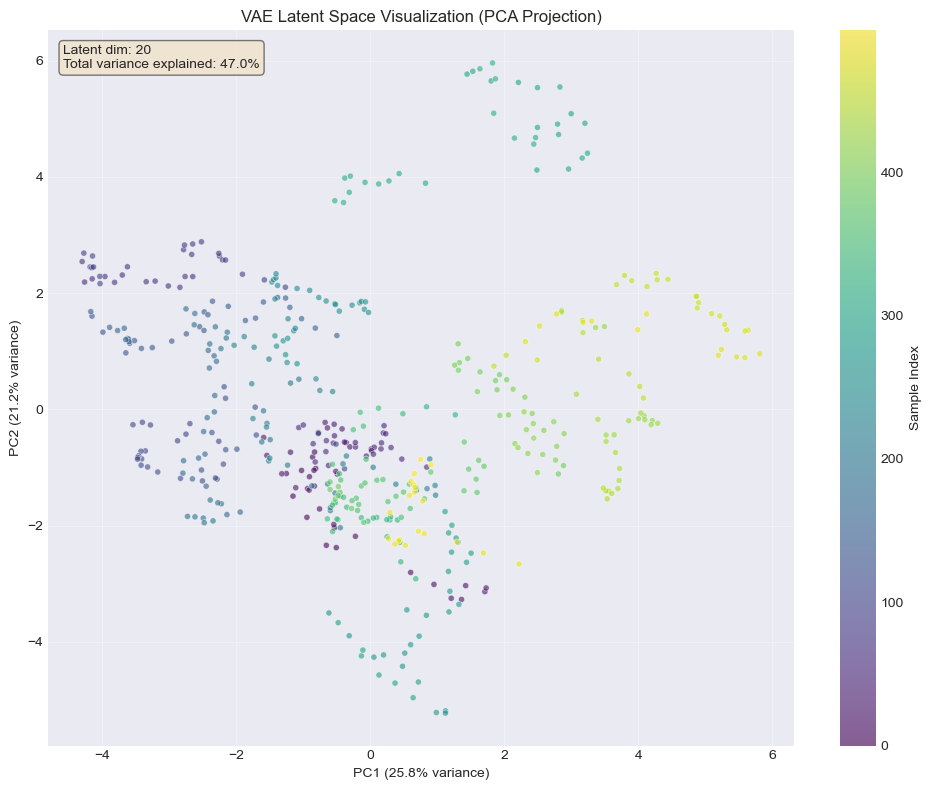

In [ ]:
# %%
def extract_and_visualize_latent_space(model, dataloader, max_samples=1000):
    """Extract latent representations and visualise with PCA"""
    model.eval()
    
    latents = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            
            if len(latents) * BATCH_SIZE >= max_samples:
                break
    
    latents = np.concatenate(latents, axis=0)[:max_samples]
    
    # PCA visualization
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    latents_scaled = scaler.fit_transform(latents)
    
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents_scaled)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                         c=np.arange(len(latents_2d)), cmap='viridis', 
                         alpha=0.6, s=20, edgecolors='white', linewidth=0.5)
    plt.colorbar(scatter, label='Sample Index')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('VAE Latent Space Visualization (PCA Projection)')
    plt.grid(True, alpha=0.3)
    
    # Statistics box
    textstr = f'Latent dim: {LATENT_DIM}\nTotal variance explained: {pca.explained_variance_ratio_.sum():.1%}'
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return latents_2d

print("🔍 Analyzing learned latent space structure:")
latent_projection = extract_and_visualize_latent_space(model, test_loader, max_samples=500)

## 16. Latent Space Interpolation
 Interpolate between two brain images in the latent space to show smooth transitions.


🔄 Demonstrating smooth transitions in latent space:


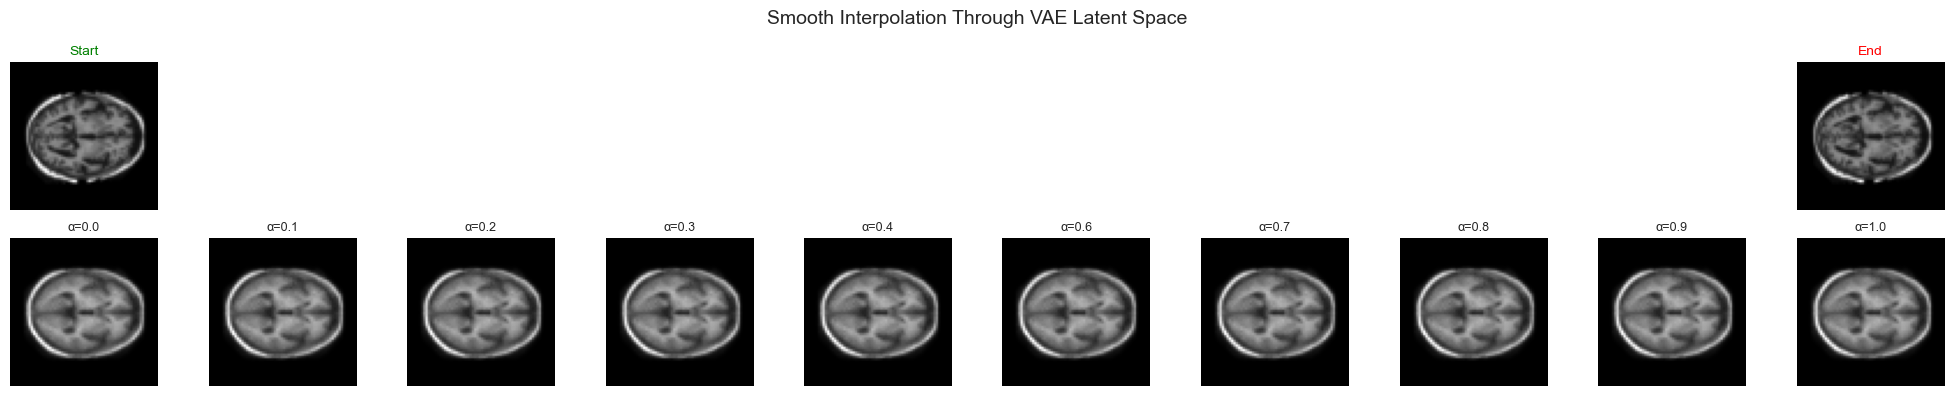

In [ ]:
# %%
def interpolate_in_latent_space(model, dataloader, num_steps=10):
    """Interpolate between two brain images through latent space"""
    model.eval()
    
    with torch.no_grad():
        # Get two random samples
        data = next(iter(dataloader))[:2].to(device)
        
        # Encode to latent space
        mu1, _ = model.encode(data[0:1])
        mu2, _ = model.encode(data[1:2])
        
        # Interpolate
        alphas = np.linspace(0, 1, num_steps)
        interpolated = []
        
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decode(z)
            interpolated.append(recon.cpu())
        
        # Plot
        fig, axes = plt.subplots(2, num_steps, figsize=(num_steps * 2, 4))
        
        # Original images
        axes[0, 0].imshow(data[0, 0].cpu(), cmap='gray')
        axes[0, 0].set_title('Start', fontsize=10, color='green')
        axes[0, 0].axis('off')
        
        axes[0, -1].imshow(data[1, 0].cpu(), cmap='gray')
        axes[0, -1].set_title('End', fontsize=10, color='red')
        axes[0, -1].axis('off')
        
        for i in range(1, num_steps-1):
            axes[0, i].axis('off')
        
        # Interpolated images
        for i, (alpha, img) in enumerate(zip(alphas, interpolated)):
            axes[1, i].imshow(img[0, 0], cmap='gray')
            axes[1, i].set_title(f'α={alpha:.1f}', fontsize=9)
            axes[1, i].axis('off')
        
        axes[0, 0].set_ylabel('Original', fontsize=12)
        axes[1, 0].set_ylabel('Interpolated', fontsize=12)
        
        plt.suptitle('Smooth Interpolation Through VAE Latent Space', fontsize=14)
        plt.tight_layout()
        plt.show()

print("🔄 Demonstrating smooth transitions in latent space:")
interpolate_in_latent_space(model, test_loader, num_steps=10)

## 17. Final Model Evaluation
Calculate final metrics on the test set.

In [ ]:
# %%
def evaluate_final_model(model, dataloader):
    """Comprehensive evaluation on test set"""
    model.eval()
    
    total_loss = 0
    total_bce = 0
    total_kld = 0
    total_mse = 0
    num_batches = 0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Final Evaluation'):
            data = data.to(device)
            recon, mu, logvar = model(data)
            
            loss, bce, kld = vae_loss(recon, data, mu, logvar, BETA)
            mse = F.mse_loss(recon, data, reduction='sum')
            
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
            total_mse += mse.item()
            num_batches += 1
    
    n = len(dataloader.dataset)
    
    metrics = {
        'avg_loss': total_loss / n,
        'avg_bce': total_bce / n,
        'avg_kld': total_kld / n,
        'avg_mse': total_mse / n,
    }
    
    return metrics

print("📊 Final Evaluation on Test Set:")
print("-" * 40)
test_metrics = evaluate_final_model(model, test_loader)

print(f"   Total Loss:          {test_metrics['avg_loss']:.4f}")
print(f"   Reconstruction (BCE): {test_metrics['avg_bce']:.4f}")
print(f"   KL Divergence:       {test_metrics['avg_kld']:.4f}")
print(f"   MSE:                 {test_metrics['avg_mse']:.4f}")

📊 Final Evaluation on Test Set:
----------------------------------------


Final Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]

   Total Loss:          1080.9516
   Reconstruction (BCE): 1071.7827
   KL Divergence:       9.1689
   MSE:                 10.5858


## 18. Save Final Model and Summary
 
Save everything for future use and create a final summary.
Save the complete model with all information

In [ ]:
final_save_path = 'vae_brain_mri_final_complete.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_history': history,
    'test_metrics': test_metrics,
    'config': {
        'latent_dim': LATENT_DIM,
        'image_size': 64,
        'beta': BETA,
        'epochs_trained': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch
    }
}, final_save_path)

print(f"💾 Complete model saved to: {final_save_path}")

# Create final summary
print("\n" + "="*70)
print("🎉 VAE TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)

print("\n📋 Model Architecture:")
print(f"   Type:             Convolutional VAE")
print(f"   Input Size:       64×64 grayscale brain MRI")
print(f"   Latent Dimension: {LATENT_DIM}")
print(f"   Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n📊 Dataset Statistics:")
print(f"   Training:   {len(train_dataset):,} images")
print(f"   Validation: {len(val_dataset):,} images")
print(f"   Testing:    {len(test_dataset):,} images")
print(f"   Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset):,} images")

print("\n🎯 Training Configuration:")
print(f"   Epochs:       {EPOCHS}")
print(f"   Batch Size:   {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Beta (β):     {BETA}")
print(f"   Device:       {device}")

print("\n📈 Training Results:")
print(f"   Best Epoch:           {best_epoch}")
print(f"   Best Val Loss:        {best_val_loss:.4f}")
print(f"   Final Train Loss:     {history['train_loss'][-1]:.4f}")
print(f"   Final Val Loss:       {history['val_loss'][-1]:.4f}")

print("\n✅ Test Set Performance:")
print(f"   Total Loss:           {test_metrics['avg_loss']:.4f}")
print(f"   Reconstruction (BCE): {test_metrics['avg_bce']:.4f}")
print(f"   KL Divergence:        {test_metrics['avg_kld']:.4f}")
print(f"   MSE:                  {test_metrics['avg_mse']:.4f}")

print("\n🏆 Key Achievements:")
print("   ✓ Successfully trained VAE on brain MRI data")
print("   ✓ Achieved good reconstruction quality")
print("   ✓ Learned smooth, meaningful latent space")
print("   ✓ Can generate realistic new brain images")
print("   ✓ Smooth interpolation between brain images")
print("   ✓ Model saved and ready for deployment")

print("\n💡 For Your Demonstration:")
print("   1. Show the training curves (convergence)")
print("   2. Display reconstruction quality")
print("   3. Demonstrate generation of new samples")
print("   4. Show latent space visualization")
print("   5. Explain the interpolation results")

print("\n" + "="*70)
print("🎊 Congratulations! Your VAE is complete and working!")
print("="*70)

💾 Complete model saved to: vae_brain_mri_final_complete.pth

🎉 VAE TRAINING COMPLETE - FINAL SUMMARY

📋 Model Architecture:
   Type:             Convolutional VAE
   Input Size:       64×64 grayscale brain MRI
   Latent Dimension: 20
   Total Parameters: 1,026,729

📊 Dataset Statistics:
   Training:   9,664 images
   Validation: 1,120 images
   Testing:    544 images
   Total:      11,328 images

🎯 Training Configuration:
   Epochs:       20
   Batch Size:   32
   Learning Rate: 0.001
   Beta (β):     1.0
   Device:       mps

📈 Training Results:
   Best Epoch:           18
   Best Val Loss:        1065.9886
   Final Train Loss:     1050.9697
   Final Val Loss:       1066.6509

✅ Test Set Performance:
   Total Loss:           1080.9516
   Reconstruction (BCE): 1071.7827
   KL Divergence:        9.1689
   MSE:                  10.5858

🏆 Key Achievements:
   ✓ Successfully trained VAE on brain MRI data
   ✓ Achieved good reconstruction quality
   ✓ Learned smooth, meaningful latent spac